In [0]:
import pandas as pd, numpy as np
import re
from sklearn.feature_extraction import DictVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer, ENGLISH_STOP_WORDS, CountVectorizer

In [0]:
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
from nltk import word_tokenize
from nltk.data import load
from nltk.stem import SnowballStemmer
taopypy_stopwords= ['https', 'air', 'cada']
my_stop_words = stopwords.words('spanish')  + taopypy_stopwords
#print (my_stop_words)

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\ferra\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [0]:
df = pd.read_csv('./tweets_public_spanish.csv', encoding='utf-16', index_col='tweet_id', sep=',') #
df_loc=df['tweet_location'].str.split(',', expand = True)
df['city']=df_loc[0]
df['country']=df_loc[1]
df.drop(['tweet_created', 'tweet_location','tweet_coord'], axis = 1, inplace = True)
df.head()

,airline_sentiment,is_reply,reply_count,retweet_count,text,user_timezone,city,country
tweet_id,,,,,,,,
942743012337123328,positive,False,0,0,"""Los pilotos de Ryanair desconvocan la huelga ...",Dublin,NaN,NaN
926857871916183553,positive,True,0,0,"@Iberia @lavecinarubia Si ,por favor las decla...",NaN,NaN,NaN
936979305720090626,neutral,True,0,0,@Iberia Me dirías por favor que costo tiene?,NaN,NaN,NaN
943983853802328064,negative,True,0,0,"@SupermanlopezN @Iberia @giroditalia Champion,...",Central Time (US & Canada),NaN,NaN
938207464457211904,negative,True,0,0,@SrtaFarrellDM @KLM @Iberia Eso de avianca es ...,Eastern Time (US & Canada),NaN,NaN


In [0]:
reach = pd.read_csv('./reach_tweets.csv', index_col= 'tweet_IDs', sep=',')['user_followers']
#reach.values

In [0]:
# bow dels models clàssics
bow = TfidfVectorizer(max_features=1500, token_pattern = r'([A-Za-z]{3,}|no)', strip_accents = 'unicode', stop_words = my_stop_words, min_df = 0.001, max_df = 0.8)
x_train_txt = bow.fit_transform(df['text'])
bow=bow.get_feature_names()
len(bow)

1183

In [0]:
# bow des del tokenizer de keras
bow = pd.read_csv('./bow_tokenizer.csv')
bow = bow['Unnamed: 0'].tolist()

In [0]:
len(bow)

16031

In [0]:
df_list = []
for search_string in bow:
    df_list.append(df[['text']].apply(lambda x: x.str.contains(search_string))
                     .sum(axis=1) 
                     .astype(int)
                     .rename(search_string))

df2 = pd.concat([df[['airline_sentiment']]] + df_list, axis=1)
df2.head()

,airline_sentiment,de,iberia,en,a,el,que,y,la,ryanair,...,responda,24x7,365,aceleremos,masoquistas,lukita,carapatras1,hsaitamle,perfectament…,miguelitoelcon1
tweet_id,,,,,,,,,,,,,,,,,,,,,
942743012337123328,positive,1,0,0,1,1,0,1,1,0,...,0,0,0,0,0,0,0,0,0,0
926857871916183553,positive,1,0,1,1,0,1,0,1,0,...,0,0,0,0,0,0,0,0,0,0
936979305720090626,neutral,0,0,1,1,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
943983853802328064,negative,1,0,0,1,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
938207464457211904,negative,1,0,0,1,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [0]:
df3 = df2.groupby('airline_sentiment').sum()
df4 = df2.groupby('airline_sentiment').sum().apply(lambda x: x/x.sum())
df_bow = df4.transpose()
df_bow['sentiment'] = df_bow['positive'] - df_bow['negative']
df_bow['reach'] = df2.iloc[:,1:].rmul(reach.values, axis=0).sum() # a df2 (taula de tuits), assignem per a cada paraula el nombre de vegades que apareix =1 
                                                                  # multiplicat pel reach del tuit. sumem les columnes i les associem amb la transposició df_bow
                                                                  # les paruales són index
df_bow['freq'] = df2.iloc[:,1:].sum()
#df_bow.tail(10)

In [0]:
from sklearn import preprocessing
scaler = preprocessing.MinMaxScaler()
df_bow[['reach', 'freq']] = scaler.fit_transform(df_bow[['reach', 'freq']])
df_bow['reach_n']=df_bow['reach']*100
df_bow['freq_n']=df_bow['freq']*100
df_bow['reach'] = df2.iloc[:,1:].rmul(reach.values, axis=0).sum()
df_bow['freq'] = df2.iloc[:,1:].sum()
df_bow['color'] = np.where(df_bow['sentiment']>=0, 'green', 'red')

In [0]:
df_bow.head(10)

airline_sentiment,negative,neutral,positive,sentiment,reach,freq,reach_n,freq_n,color
de,0.496838,0.318880,0.184282,-0.312556,50905869,5535,87.106493,70.798158,red
iberia,0.587196,0.306843,0.105960,-0.481236,564220,453,0.965453,5.794321,red
en,0.528557,0.298135,0.173307,-0.355250,36108411,5095,61.786138,65.170120,red
a,0.481581,0.325147,0.193272,-0.288309,58306188,7818,99.769391,100.000000,red
el,0.494052,0.322137,0.183812,-0.310240,42805016,4287,73.244891,54.834996,red
que,0.630635,0.238512,0.130853,-0.499781,9205479,2285,15.751759,29.227424,red
y,0.496531,0.314694,0.188776,-0.307755,42511235,4900,72.742194,62.675876,red
la,0.492673,0.317516,0.189812,-0.302861,26660367,4299,45.619319,54.988488,red
ryanair,0.510490,0.328671,0.160839,-0.349650,171071,143,0.292724,1.829112,red
con,0.474710,0.318794,0.206497,-0.268213,13804729,2155,23.621668,27.564595,red


In [0]:
df_filter=df_bow[(df_bow['sentiment'] < 0.1)|(df_bow['sentiment'] > -0.2)]
stopwords2 = df_filter.index.tolist()
len(stopwords2)
print(len('stopwords2'), stopwords2)

10 ['de', 'iberia', 'en', 'a', 'el', 'que', 'y', 'la', 'ryanair', 'con', 'no', 'un', 'por', 'los', 'es', 'me', 'vuelo', 'para', 'una', 'mi', 'al', 'del', 'se', 'lo', 'las', 'hola', 'más', 'si', 'madrid', 'solo', 'vuelos', 'gracias', 'su', 'mejor', 'pero', 'desde', 'destino', 'suerte', 'precio', 'destinos', 'como', 'europeos', 'click', '79', 'ya', 'españa', 'te', '2', 'huelga', 'he', 'años', 'avión', 'sus', 'así', 'vueling', 'sin', 'o', 'pilotos', 'maleta', 'muy', 'fue', 'cuando', 'holacolombia', 'vía', 'yo', 'nos', 'hace', 'ha', 'tengo', 'hay', 'euros', 'hacer', 'spanair', 'q', 'días', 'porque', 'qué', 'web', 'equipaje', 'ni', 'tu', '…', 'accidente', 'le', 'video', 'hoy', 'son', 'aeropuerto', '5', 'pasajeros', 'está', 'todo', 'han', 'volar', 'billete', '5022', 'dos', 'les', 'horas', 'décadas', 'letal', 'estoy', 'nada', 'día', 'eso', 'esta', 'número', 'europa', 'puedo', 'siempre', 'este', 'servicio', 'viajar', 'hasta', 'plus', 'vez', 'billetes', 'maletas', 'ahora', '3', 'todos', '25', '

In [0]:
import holoviews as hv
from math import sqrt
from bokeh.io import output_notebook,show, output_file
from bokeh.models import Plot, Range1d, MultiLine, Circle, HoverTool, TapTool, BoxSelectTool, Legend
from bokeh.models.graphs import from_networkx, NodesAndLinkedEdges, EdgesAndLinkedNodes, ColumnDataSource
from bokeh.palettes import Spectral4
from bokeh.plotting import show, figure
#from bokeh.transform import factor_cmap

In [0]:
import bokeh

bokeh.__version__

'0.12.16'

<img src='data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAAAEAAAABACAYAAACqaXHeAAAABHNCSVQICAgIfAhkiAAAAAlwSFlz
AAAB+wAAAfsBxc2miwAAABl0RVh0U29mdHdhcmUAd3d3Lmlua3NjYXBlLm9yZ5vuPBoAAA6zSURB
VHic7ZtpeFRVmsf/5966taWqUlUJ2UioBBJiIBAwCZtog9IOgjqACsogKtqirT2ttt069nQ/zDzt
tI4+CrJIREFaFgWhBXpUNhHZQoKBkIUASchWla1S+3ar7r1nPkDaCAnZKoQP/D7mnPOe9/xy76n3
nFSAW9ziFoPFNED2LLK5wcyBDObkb8ZkxuaoSYlI6ZcOKq1eWFdedqNzGHQBk9RMEwFAASkk0Xw3
ETacDNi2vtvc7L0ROdw0AjoSotQVkKSvHQz/wRO1lScGModBFbDMaNRN1A4tUBCS3lk7BWhQkgpD
lG4852/+7DWr1R3uHAZVQDsbh6ZPN7CyxUrCzJMRouusj0ipRwD2uKm0Zn5d2dFwzX1TCGhnmdGo
G62Nna+isiUqhkzuKrkQaJlPEv5mFl2fvGg2t/VnzkEV8F5ioioOEWkLG86fvbpthynjdhXYZziQ
x1hC9J2NFyi8vCTt91Fh04KGip0AaG9zuCk2wQCVyoNU3Hjezee9bq92duzzTmxsRJoy+jEZZZYo
GTKJ6SJngdJqAfRzpze0+jHreUtPc7gpBLQnIYK6BYp/uGhw9YK688eu7v95ysgshcg9qSLMo3JC
4jqLKQFBgdKDPoQ+Pltb8dUyQLpeDjeVgI6EgLIQFT5tEl3rn2losHVsexbZ3EyT9wE1uGdkIPcy
BGxn8QUq1QrA5nqW5i2tLqvrrM9NK6AdkVIvL9E9bZL/oyfMVd/jqvc8LylzRBKDJSzIExwhQzuL
QYGQj4rHfFTc8mUdu3E7yoLtbTe9gI4EqVgVkug2i5+uXGo919ixbRog+3fTbQ8qJe4ZOYNfMoTI
OoshUNosgO60AisX15aeI2PSIp5KiFLI9ubb1vV3Qb2ltwLakUCDAkWX7/nHKRmmGIl9VgYsUhJm
2NXjKYADtM1ygne9QQDIXlk49FBstMKx66D1v4+XuQr7vqTe0VcBHQlRWiOCbmmSYe2SqtL6q5rJ
zsTb7lKx3FKOYC4DoqyS/B5bvLPxvD9Qtf6saxYLQGJErmDOdOMr/zo96km1nElr8bmPOBwI9COv
HnFPRIwmkSOv9kcAS4heRsidOkpeWBgZM+UBrTFAXNYL5Vf2ii9c1trNzpYdaoVil3WIc+wdk+gQ
noie3ecCcxt9ITcLAPWt/laGEO/9U6PmzZkenTtsSMQ8uYywJVW+grCstAvCIaAdArAsIWkRDDs/
KzLm2YcjY1Lv0UdW73HabE9n6V66cxSzfEmuJssTpKGVp+0vHq73FwL46eOjpMpbRAnNmJFrGJNu
Ukf9Yrz+3rghiumCKNXXWPhLYcjxGsIpoCMsIRoFITkW8AuyM8jC1+/QLx4bozCEJIq38+1rtpR6
V/yzb8eBlRb3fo5l783N0CWolAzJHaVNzkrTzlEp2bQ2q3TC5gn6wpnoQAmwSiGh2GitnTmVMc5O
UyfKWUKCIsU7+fZDKwqdT6DDpvkzAX4/+AMFjk0tDp5GRXLpQ2MUmhgDp5gxQT8+Y7hyPsMi8uxF
71H0oebujHALECjFKaW9Lm68n18wXp2kVzIcABytD5iXFzg+WVXkegpAsOOYziqo0OkK76GyquC3
ltZAzMhhqlSNmmWTE5T6e3IN05ITFLM4GdN0vtZ3ob8Jh1NAKXFbm5PtLU/eqTSlGjkNAJjdgn/N
aedXa0tdi7+t9G0FIF49rtMSEgAs1kDLkTPO7ebm4IUWeyh1bKomXqlgMG6kJmHcSM0clYLJ8XtR
1GTnbV3F6I5wCGikAb402npp1h1s7LQUZZSMIfALFOuL3UUrfnS8+rez7v9qcold5tilgHbO1fjK
9ubb17u9oshxzMiUBKXWqJNxd+fqb0tLVs4lILFnK71H0Ind7uiPgACVcFJlrb0tV6DzxqqTIhUM
CwDf1/rrVhTa33/3pGPxJYdQ2l2cbgVcQSosdx8uqnDtbGjh9SlDVSMNWhlnilfqZk42Th2ZpLpf
xrHec5e815zrr0dfBZSwzkZfqsv+1FS1KUknUwPARVvItfKUY+cn57yP7qv07UE3p8B2uhUwLk09
e0SCOrK+hbdYHYLjRIl71wWzv9jpEoeOHhGRrJAzyEyNiJuUqX0g2sBN5kGK6y2Blp5M3lsB9Qh4
y2Ja6x6+i0ucmKgwMATwhSjdUu49tKrQ/pvN5d53ml2CGwCmJipmKjgmyuaXzNeL2a0AkQ01Th5j
2DktO3Jyk8f9vcOBQHV94OK+fPumJmvQHxJoWkaKWq9Vs+yUsbq0zGT1I4RgeH2b5wef7+c7bl8F
eKgoHVVZa8ZPEORzR6sT1BzDUAD/d9F78e2Tzv99v8D+fLVTqAKAsbGamKey1Mt9Ann4eH3gTXTz
idWtAJ8PQWOk7NzSeQn/OTHDuEikVF1R4z8BQCy+6D1aWRfY0tTGG2OM8rRoPaeIj5ZHzJxszElN
VM8K8JS5WOfv8mzRnQAKoEhmt8gyPM4lU9SmBK1MCQBnW4KONT86v1hZ1PbwSXPw4JWussVjtH9Y
NCoiL9UoH/6PSu8jFrfY2t36erQHXLIEakMi1SydmzB31h3GGXFDFNPaK8Rme9B79Ixrd0WN+1ij
NRQ/doRmuFLBkHSTOm5GruG+pFjFdAmorG4IXH1Qua6ASniclfFtDYt+oUjKipPrCQB7QBQ2lrgP
fFzm+9XWUtcqJ3/5vDLDpJ79XHZk3u8nGZ42qlj1+ydtbxysCezrydp6ugmipNJ7WBPB5tydY0jP
HaVNzs3QzeE4ZpTbI+ZbnSFPbVOw9vsfnVvqWnirPyCNGD08IlqtYkh2hjZ5dErEQzoNm+6ykyOt
Lt5/PQEuSRRKo22VkydK+vvS1XEKlhCJAnsqvcVvH7f/ZU2R67eXbMEGAMiIV5oWZWiWvz5Fv2xG
sjqNJQRvn3Rs2lji/lNP19VjAQDgD7FHhujZB9OGqYxRkZxixgRDVlqS6uEOFaJUVu0rPFzctrnF
JqijImVp8dEKVWyUXDk92zAuMZ6bFwpBU1HrOw6AdhQgUooChb0+ItMbWJitSo5Ws3IAOGEOtL53
0vHZih9sC4vtofZ7Qu6523V/fmGcds1TY3V36pUsBwAbSlxnVh2xLfAD/IAIMDf7XYIkNmXfpp2l
18rkAJAy9HKFaIr/qULkeQQKy9zf1JgDB2uaeFNGijo5QsUyacNUUTOnGO42xSnv4oOwpDi1zYkc
efUc3I5Gk6PhyTuVKaOGyLUAYPGIoY9Pu/atL/L92+4q9wbflRJ2Trpm/jPjdBtfnqB/dIThcl8A
KG7hbRuKnb8qsQsVvVlTrwQAQMUlf3kwJI24Z4JhPMtcfng5GcH49GsrxJpGvvHIaeem2ma+KSjQ
lIwUdYyCY8j4dE1KzijNnIP2llF2wcXNnsoapw9XxsgYAl6k+KzUXbi2yP3KR2ecf6z3BFsBICdW
nvnIaG3eHybqX7vbpEqUMT+9OL4Qpe8VON7dXuFd39v19FoAABRVePbGGuXTszO0P7tu6lghUonE
llRdrhArLvmKdh9u29jcFiRRkfLUxBiFNiqSU9icoZQHo5mYBI1MBgBH6wMNb+U7Pnw337H4gi1Y
ciWs+uks3Z9fztUvfzxTm9Ne8XXkvQLHNytOOZeiD4e0PgkAIAYCYknKUNUDSXEKzdWNpnil7r4p
xqkjTarZMtk/K8TQ6Qve78qqvXurGwIJqcOUKfUWHsm8KGvxSP68YudXq4pcj39X49uOK2X142O0
Tz5/u/7TVybqH0rSya6ZBwD21/gubbrgWdDgEOx9W
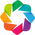

Loading BokehJS ...

In [0]:
hv.extension('bokeh')
output_notebook()

In [0]:
hover = HoverTool(line_policy='none',tooltips=[('word','@index'), ('reach', '@reach'), ('sentiment', '@sentiment'), ('frequency','@freq')])
source=ColumnDataSource(df_bow)
#cmap = factor_cmap('sent', palette=Spectral4, factors=sorted(df_bow.sent.unique()), end=1)
plot = figure(plot_width=900, plot_height=600, title="Representació paraules clau",
              tools=['tap', hover, 'box_zoom','lasso_select','zoom_out', 'pan', 'undo', 'reset', 'save'])
plot.xaxis.axis_label = "Valoració del sentiment"
plot.yaxis.axis_label = "Freqüencia (normalitzada, max =100)"
plot.circle(source=source, x='sentiment', y='freq_n', size='reach_n', fill_color='color', alpha=0.5)#, source=ColumnDataSource(df_bow))

show(plot)

In [0]:
df_bow_ps = df_bow[df_bow['sentiment']>=0][df_bow['freq']>=10]
df_bow_ps = df_bow_ps[['sentiment','reach','freq']].sort_values(by='sentiment',ascending= False)

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """Entry point for launching an IPython kernel.


In [0]:
df_bow_ps.head(50)

airline_sentiment,sentiment,reach,freq
iker,0.866667,13075,15
rebajas,0.692308,44533,26
placer,0.666667,17734,12
lanzan,0.619048,49290,21
reconocido,0.600000,9910,10
disfruta,0.588235,35322,17
bajas,0.586207,45750,29
excelente,0.583333,533186,12
disfrutar,0.545455,23882,11
quinto,0.545455,33853,11


In [0]:

df_bow_ps.head(50)

airline_sentiment,sentiment,reach,freq
iker,0.866667,13075,15
rebajas,0.692308,44533,26
placer,0.666667,17734,12
lanzan,0.619048,49290,21
reconocido,0.600000,9910,10
disfruta,0.588235,35322,17
bajas,0.586207,45750,29
excelente,0.583333,533186,12
disfrutar,0.545455,23882,11
quinto,0.545455,33853,11


In [0]:
df0=df2.copy()
df0['reach']=reach
reach_p = df0['reach'][df0['airline_sentiment']=='positive']
df2p = df0[df0['airline_sentiment']=='positive']
df3p = df2p.groupby('airline_sentiment').sum()
df_bow_p = df3p.transpose()
df_bow_p['reach'] = df2p.iloc[:,1:].rmul(reach_p.values, axis=0).sum()
df_bow_p.sort_values(by='positive',ascending= False).head(25)

airline_sentiment,positive,reach
reach,8166863,3015649238495
a,1511,8140641
e,1511,8142539
i,1510,8100209
r,1509,8097532
s,1487,8128820
o,1474,8133341
c,1446,8114518
n,1440,7945617
t,1416,7942396


In [0]:
reach_n = df0['reach'][df0['airline_sentiment']=='negative']
df2n = df0[df0['airline_sentiment']=='negative']
df3n = df2n.groupby('airline_sentiment').sum()
df_bow_n = df3n.transpose()
df_bow_n['reach'] = df2n.iloc[:,1:].rmul(reach_n.values, axis=0).sum()
df_bow_n.sort_values(by='negative',ascending= False).head(25)

airline_sentiment,negative,reach
reach,27804622,55196737372044
e,3767,27774887
a,3765,27634611
i,3759,27471510
r,3756,27663640
o,3736,27641140
s,3722,27568107
n,3677,27631146
t,3603,27251064
c,3586,27137313
